In [1]:
# ===== Environment Setup

# Uncomment to download and install keras-retinanet since it's not available in conda yet
# !git clone https://github.com/fizyr/keras-retinanet
# !pip install keras-retinanet/. --user
# !python keras-retinanet/setup.py build_ext --inplace

# Uncomment to Download pretrained model. Make sure to check it exists.
# !wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5

# Add to path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'keras-retinanet'))

In [2]:
%matplotlib inline

import xml.etree.ElementTree as ET
import numpy as np
import keras
import math
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
from os import listdir, walk
from os.path import join
from keras_retinanet import models
from keras_retinanet.models import backbone,load_model,convert_model
from keras_retinanet.bin.train import create_generators,create_models,create_callbacks
from keras_retinanet.utils.config import read_config_file,parse_anchor_parameters
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

tf.set_random_seed(31) # SEEDS MAKE RESULTS MORE REPRODUCABLE
np.random.seed(17)
classes = ['cigarette']

Using TensorFlow backend.


In [6]:
# ===== Prepare Data

# To read PASCAL VOC format xml label
def convert_annotation(image_id,filename):
    in_file = open(os.path.join(os.getcwd(), 'dataset/train/%s.xml'%(image_id)))
    out_file = open(filename, 'a')
    tree=ET.parse(in_file)
    root = tree.getroot()
    
    if root.iter('object') is not None:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            
            xmlbox = obj.find('bndbox')
            x1 = math.ceil(float(xmlbox.find('xmin').text))
            y1 = math.ceil(float(xmlbox.find('ymin').text))
            x2 = math.ceil(float(xmlbox.find('xmax').text))
            y2 = math.ceil(float(xmlbox.find('ymax').text))
            if x1 == x2 or y1 == y2:
                continue
                
            out_file.write(os.path.join(os.getcwd(), f'dataset/train/{image_id}.jpg,{x1},{y1},{x2},{y2},{cls}\n'))
    else:
        out_file.write(os.path.join(os.getcwd(), f'dataset/train/{image_id}.jpg,,,,,\n'))

In [7]:
_,_,image_ids = next(walk(os.path.join(os.getcwd(), 'dataset/train')))
image_ids = [i[:-4] for i in image_ids]

# Split
train_ids,val_ids = train_test_split(image_ids,random_state=31,test_size=0.25)

# Parse Train Data
open('annotations.csv','w')
for image_id in train_ids:
    convert_annotation(image_id,'annotations.csv')

# Parse Validation Data
open('val_annotations.csv','w')
for image_id in val_ids:
    convert_annotation(image_id,'val_annotations.csv')
    
print(len(train_ids),len(val_ids))

with open('classes.csv','w') as f:
    f.write('cigarette,0\n')
    
# Anchor Parameters
# Anchor parameters are used to decide how anchor boxes will be generated for the model.
with open('config.ini','w') as f:
    f.write('[anchor_parameters]\nsizes   = 32 64 128 256 512\nstrides = 8 16 32 64 128\nratios  = 0.25 0.5 0.75 1 1.5 2 4 6 8 10\nscales  = 0.5 1 2\n')
    
# Hyperparameters
b = backbone('resnet50')
class args:
    batch_size = 32
    config = read_config_file('config.ini')
    random_transform = True # Image augmentation
    annotations = 'annotations.csv'
    val_annotations = 'val_annotations.csv'
    classes = 'classes.csv'
    image_min_side = 256
    image_max_side = 256
    dataset_type = 'csv'
    tensorboard_dir = ''
    evaluation = False
    snapshots = True
    snapshot_path = "saved/"
    backbone = 'resnet50'
    epochs = 70
    steps = len(train_ids)//(batch_size)
    weighted_average = True

train_gen,valid_gen = create_generators(args,b.preprocess_image)

300 100


In [8]:
# Image Augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Execute 1 to 9 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((1, 9),
            [

                        # Blur each image with varying strength using
                        # gaussian blur (sigma between 0 and .5),
                        # average/uniform blur (kernel size 1x1)
                        # median blur (kernel size 1x1).
                        iaa.OneOf([
                            iaa.GaussianBlur((0,0.5)),
                            iaa.AverageBlur(k=(1)),
                            iaa.MedianBlur(k=(1)),
                        ]),

                        # Sharpen each image, overlay the result with the original
                        # image using an alpha between 0 (no sharpening) and 1
                        # (full sharpening effect).
                        iaa.Sharpen(alpha=(0, 0.25), lightness=(0.75, 1.5)),

                        # Add gaussian noise to some images.
                        # In 50% of these cases, the noise is randomly sampled per
                        # channel and pixel.
                        # In the other 50% of all cases it is sampled once per
                        # pixel (i.e. brightness change).
                        iaa.AdditiveGaussianNoise(
                            loc=0, scale=(0.0, 0.01*255), per_channel=0.5
                        ),

                        # Either drop randomly 1 to 10% of all pixels (i.e. set
                        # them to black) or drop them on an image with 2-5% percent
                        # of the original size, leading to large dropped
                        # rectangles.
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5),
                            iaa.CoarseDropout(
                                (0.03, 0.15), size_percent=(0.02, 0.05),
                                per_channel=0.2
                            ),
                        ]),

                        # Add a value of -5 to 5 to each pixel.
                        iaa.Add((-5, 5), per_channel=0.5),

                        # Change brightness of images (85-115% of original value).
                        iaa.Multiply((0.85, 1.15), per_channel=0.5),

                        # Improve or worsen the contrast of images.
                        iaa.ContrastNormalization((0.75, 1.25), per_channel=0.5),

                        # Convert each image to grayscale and then overlay the
                        # result with the original with random alpha. I.e. remove
                        # colors with varying strengths.
                        iaa.Grayscale(alpha=(0.0, 0.25)),

                        # In some images distort local areas with varying strength.
                        sometimes(iaa.PiecewiseAffine(scale=(0.001, 0.01)))
                    ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)
def augment_train_gen(train_gen,visualize=False):
    '''
    Creates a generator using another generator with applied image augmentation.
    Args
        train_gen  : keras-retinanet generator object.
        visualize  : Boolean; False will convert bounding boxes to their anchor box targets for the model.
    '''
    imgs = []
    boxes = []
    targets = []
    size = train_gen.size()
    idx = 0
    while True:
        while len(imgs) < args.batch_size:
            image       = train_gen.load_image(idx % size)
            annotations = train_gen.load_annotations(idx % size)
            image,annotations = train_gen.random_transform_group_entry(image,annotations)
            imgs.append(image)            
            boxes.append(annotations['bboxes'])
            targets.append(annotations)
            idx += 1
        if visualize:
            imgs = seq.augment_images(imgs)
            imgs = np.array(imgs)
            boxes = np.array(boxes)
            yield imgs,boxes
        else:
            imgs = seq.augment_images(imgs)
            imgs,targets = train_gen.preprocess_group(imgs,targets)
            imgs = train_gen.compute_inputs(imgs)
            targets = train_gen.compute_targets(imgs,targets)
            imgs = np.array(imgs)
            yield imgs,targets
        imgs = []
        boxes = []
        targets = []

In [9]:
# ===== Create Model
model, training_model, prediction_model = create_models(
            backbone_retinanet=b.retinanet,
            num_classes=train_gen.num_classes(),
            weights=None,
            multi_gpu=False,
            freeze_backbone=True,
            lr=1e-3,
            config=args.config
        )
callbacks = create_callbacks(
    model,
    training_model,
    prediction_model,
    valid_gen,
    args,
)
# Load weights
training_model.load_weights('resnet50_coco_best_v2.1.0.h5',skip_mismatch=True,by_name=True)

W0823 21:36:50.933325 140540385224512 deprecation_wrapper.py:119] From /home/steveyamada2017/anaconda3/envs/tf_retina_net/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 21:36:50.935128 140540385224512 deprecation_wrapper.py:119] From /home/steveyamada2017/anaconda3/envs/tf_retina_net/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 21:36:50.948329 140540385224512 deprecation_wrapper.py:119] From /home/steveyamada2017/anaconda3/envs/tf_retina_net/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 21:36:50.974743 140540385224512 deprecation_wrapper.py:119] From /home/steveyamada2017/anaconda3/envs/tf_retina_net/lib/python3.7/site-packages/keras/backend/

In [10]:
# ===== Train

training_model.fit_generator(generator=augment_train_gen(train_gen),
        steps_per_epoch=args.steps,
        epochs=args.epochs,
        verbose=1,
        callbacks=callbacks)

Epoch 1/70
9/9 [==============================] - 21s 2s/step - loss: 3.3907 - regression_loss: 2.4541 - classification_loss: 0.9366

Epoch 00001: saving model to saved/resnet50_csv_01.h5
Epoch 2/70
9/9 [==============================] - 15s 2s/step - loss: 2.2166 - regression_loss: 1.8356 - classification_loss: 0.3810

Epoch 00002: saving model to saved/resnet50_csv_02.h5
Epoch 3/70
9/9 [==============================] - 21s 2s/step - loss: 1.8461 - regression_loss: 1.5389 - classification_loss: 0.3072

Epoch 00003: saving model to saved/resnet50_csv_03.h5
Epoch 4/70
9/9 [==============================] - 19s 2s/step - loss: 1.7146 - regression_loss: 1.4483 - classification_loss: 0.2663

Epoch 00004: saving model to saved/resnet50_csv_04.h5
Epoch 5/70
9/9 [==============================] - 22s 2s/step - loss: 1.6845 - regression_loss: 1.4269 - classification_loss: 0.2575

Epoch 00005: saving model to saved/resnet50_csv_05.h5
Epoch 6/70
9/9 [==============================] - 18s 2s/ste


Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 41/70
9/9 [==============================] - 22s 2s/step - loss: 1.0423 - regression_loss: 0.9137 - classification_loss: 0.1285

Epoch 00041: saving model to saved/resnet50_csv_41.h5
Epoch 42/70
9/9 [==============================] - 18s 2s/step - loss: 1.0368 - regression_loss: 0.9042 - classification_loss: 0.1326

Epoch 00042: saving model to saved/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
Epoch 43/70
9/9 [==============================] - 20s 2s/step - loss: 1.0495 - regression_loss: 0.9178 - classification_loss: 0.1316

Epoch 00043: saving model to saved/resnet50_csv_43.h5
Epoch 44/70
9/9 [==============================] - 21s 2s/step - loss: 0.9830 - regression_loss: 0.8604 - classification_loss: 0.1226

Epoch 00044: saving model to saved/resnet50_csv_44.h5

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

In [11]:
# ===== Reload Model for Inference
model_path_new = os.path.join('saved', 'resnet50_csv_70.h5')
prediction_model.load_weights(model_path_new,skip_mismatch=True,by_name=True)

processing time:  0.2752504348754883


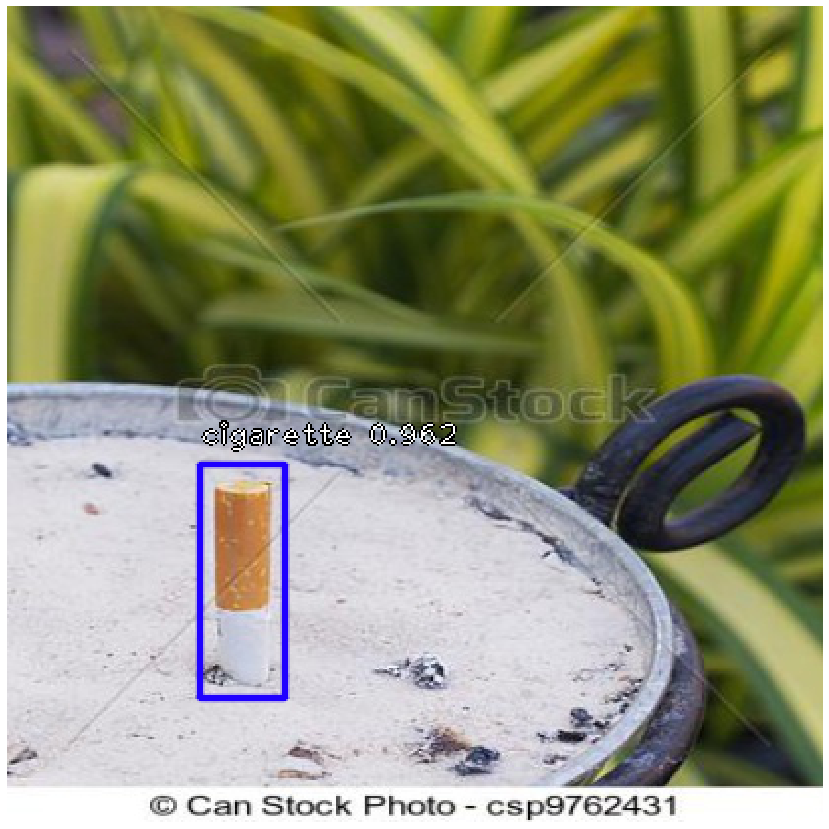

processing time:  0.2363426685333252


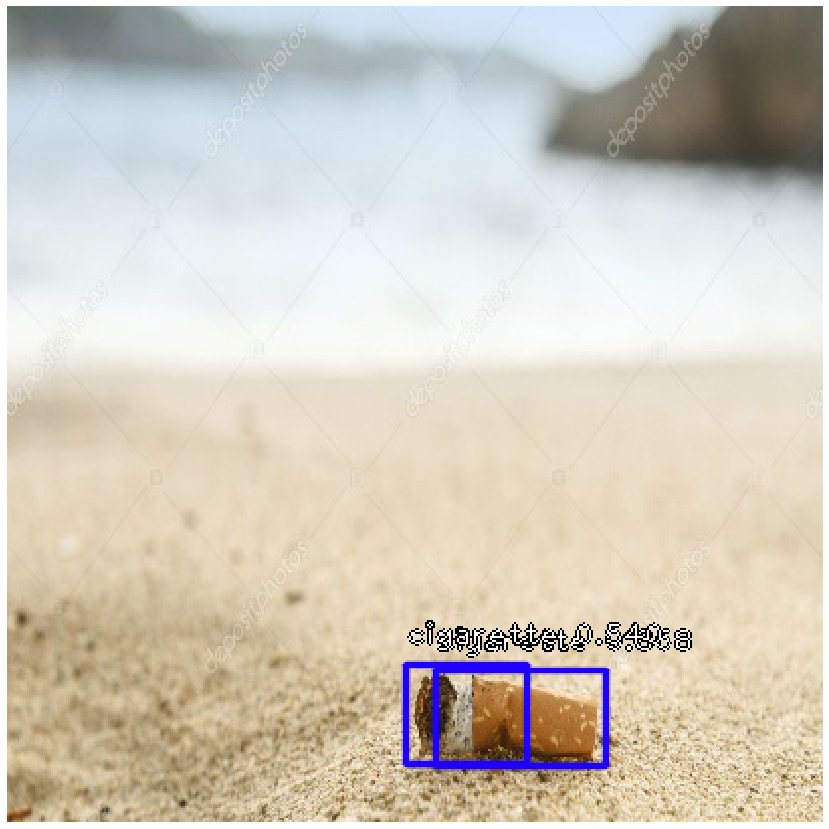

processing time:  0.2192389965057373


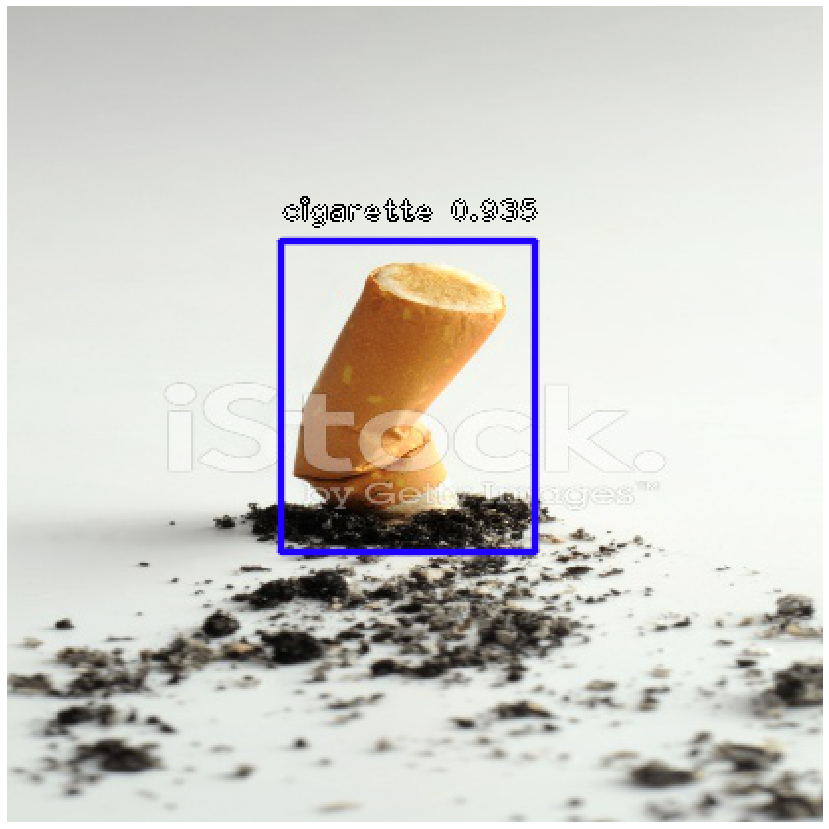

processing time:  0.19483566284179688


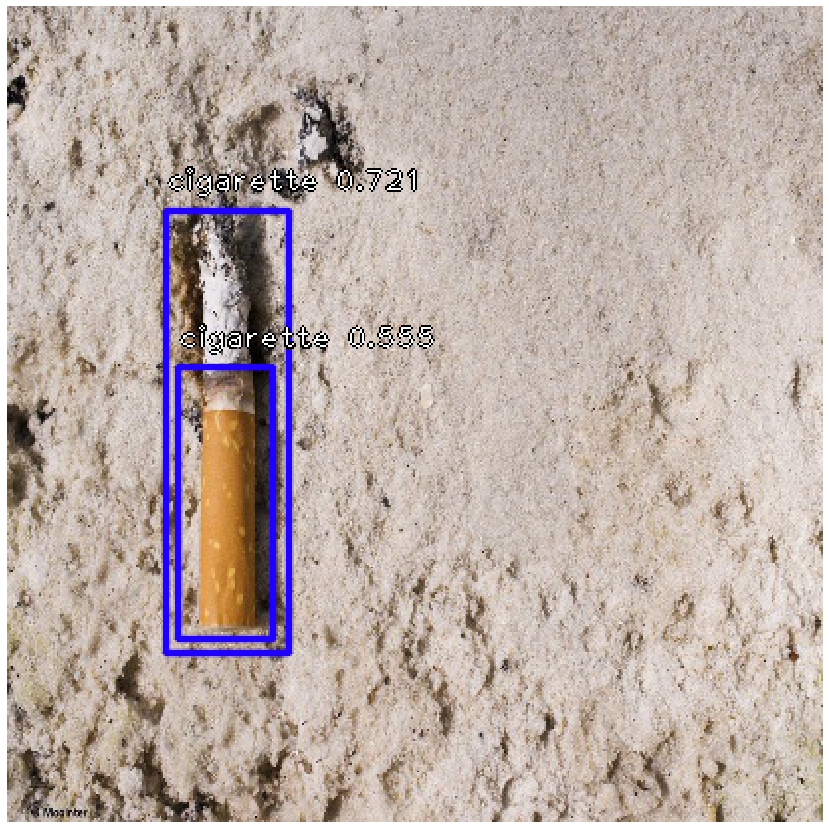

processing time:  0.1963791847229004


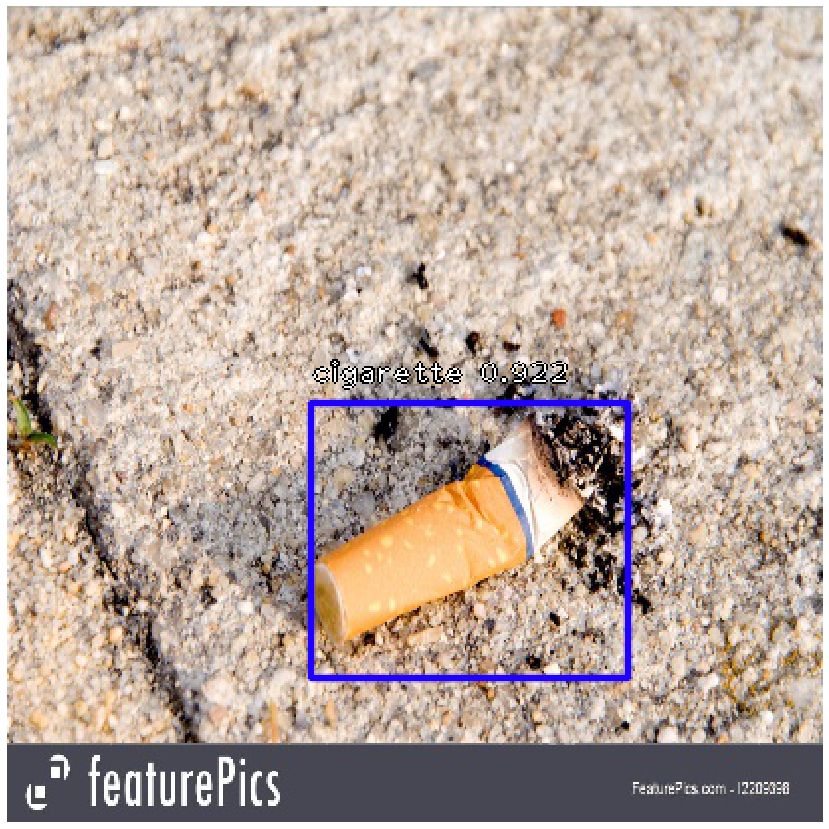

processing time:  0.19113421440124512


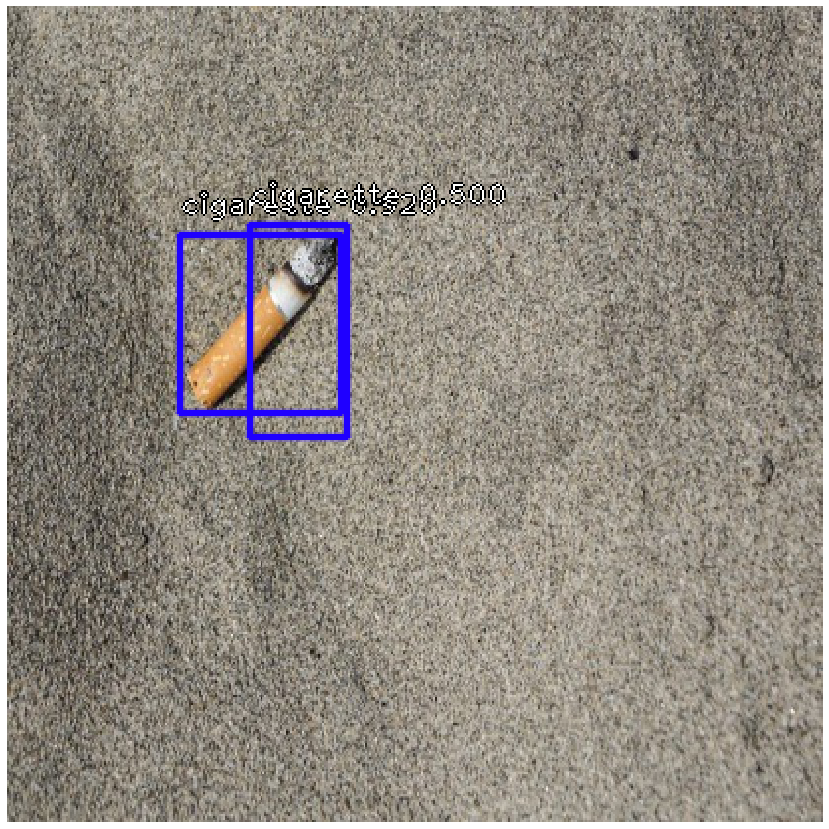

In [15]:
# ===== Visualize

test_dir = 'dataset/test'
for index, item in enumerate(os.listdir(test_dir)):
    if index < 10 and item.endswith('jpg'):
        image = read_image_bgr(os.path.join(test_dir, item))

        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

        # preprocess image for network
        image = preprocess_image(image)
        image, scale = resize_image(image)

        # process image
        start = time.time()
        boxes, scores, labels = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))
        print("processing time: ", time.time() - start)

        # correct for image scale
        boxes /= scale

        # visualize detections
        labels_to_names = {0 : 'cigarette'}
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            # scores are sorted so we can break
            if score < 0.5:
                break

            color = label_color(label)

            b = box.astype(int)
            draw_box(draw, b, color=color)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()